## KAIM 2017
#### Anand - December, 24 
## Convolutional Neural Networks Tutorial

#### Movitvation
- Automatic Feature Selecture and Extraction
- Heirarchical Organization
    - The representational complexity increases with depth
    - Differentiation based on extracted features
- Sensitive to features in a local neighbourhood - but not at pixel level.

$$
---------
$$

#### Convolution Operation
<table style="width:100%">
    <tr>
    <td><img src="conv.gif"></td>
    <td><img src="receptive_field.png"></td>
    <tr>
    <tr>
    <td>Convolution Operation</td>
    <td>Receptive Field</td>
  </tr>
</table>

**Note: ** Convolution *is* Cross-Correlation with a flipped kernel.
$$
\begin{aligned}
I \ast K &= \sum_{m=0}^{k_1-1}\sum_{n=1}^{k_2 -1}I(i+m, j+n)K(m,n)  \quad \text{(Cross-Correlation)} \\
I \ast K &= \sum_{m=0}^{k_1-1}\sum_{n=1}^{k_2 -1}I(i-m, j-n)K(m,n)  \quad \text{(Convolution)}
\end{aligned}
$$

##### Variants
<table style="width:100%">
  <tr>
    <td><img src="conv_.gif"></td>
    <td><img src="padding_.gif"></td>
    <td><img src="stride_.gif"></td>
    <td><img src="transpose_.gif"></td>
  </tr>
   <tr>
    <td>Simple Convolution</td>
    <td>Padding Convolution</td>
    <td>Strided Convolution</td>
    <td>Transposed Convolution</td>
  </tr>
</table>

$$
---------
$$

##### Properties
- **Parameter Sharing** - In traditional networks, each node is associated with a unique weight and it is used only for that node. These are called as *tied weights*. In CNNs, the filter/kernel slides through the input, and therefore, multiple nodes share the same weight $\Rightarrow$ learn just one set of parameter for the entire input. (Reduced space complexity).
- **Sparse Interactions** - Kernel size $\ll$ image size $\Rightarrow$ restricting the features to a local neighbourhood. However, the sparsity decreases for deeper networks since the receptive fields are larger. 
- **Equivariance to translation** - Since the convolution operation inherently is equivariant to translation and lateral inversion. However, it is not equivariant to other transformations like rotation etc. Therefore, no matter where the feature is present, the network can capture it correctly at that neightbourhood.  

**Note: ** Equivariance is not the same as Invariance. Equivariance means that the output varies with the input. Invariance means the ouput remains the same irrespective of any variance in the input.

$$
---------
$$

#### Applications 
- Image Classification
- Image Retrieval
- Semantic Segmentation
- Detection
- Super Resolution
- Pose Estimation 
- Image Captioning 
- Style Transfer and so on...

*The above animations were adapted from [Convolution arithmetic](https://github.com/vdumoulin/conv_arithmetic)*

In [6]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim                        
from torch.autograd import Variable

from time import time
import pylab as plt
%matplotlib auto

Using matplotlib backend: TkAgg


## Convolutional Neural Networks

### Architecture
CNNs are models that perform sequential operations on the input data. In this tutorial, a simple 3-layer CNN is constructed to classify the famous MNIST handwritten digits data.

##### Convolution Layer
Perform convolution with a fixed kernel size that determines the size of the ouput features. The `conv2D` function in PyTorch performs a $2D$ convolution and takes in a $4D$ tensor of size $\underbrace{N_{Samples} \times m \times n}_\text{input} \times N_{channels}$.

$$
---------
$$

##### Fully Connected Layer
This is the last layer of CNNs where instead of convolution, the usual discrete *tied* weights are used. it compresses the information from all the layers into a vector of the different classes in the data. Extracts the features and returns the class that best represent it. This is added in the last layer because we want the output class to have strong correlation between the *highest-level* features extracted by the network.

$$
---------
$$

##### Pooling Layer
Pooling layer essentially is a *summary* statistic of the local neighbourhoods. it is a *downsampling* layer, where some compressing operation within the kernel is applied. Since the operation describes the neighbourhood, it makes the feature in that neighbourhood to be invariant. Therefore, the subsequent layers become invariant to the transformation of the previous layer's features. Beware, Pooling is **not** reccomended because it may cause underfitting due to feature loss. If theyare used, they must be carefully used at selective layers where invariance is required.

In this network, we simply take the maximum within each neighbourhood. It can be though as a strided convolution.
$$
\left[
\begin{array}{c|c}
M & N \\
\hline
R & S
\end{array}
\right]_{N \times N} = \left[
\begin{array}{c|c}
\max(M) & \max(N) \\
\hline
\max(R) & \max(S)
\end{array}
\right]_{2 \times 2}$$

$$
---------
$$

#### Activation Function
Activation function is essentially the nonlinearity introduced in the layer to learn complex features because convolution and pooling are *linear* operations. Note that these nonlinear mappings are point-wise mappings. Some advantages of RELU include sparsity induction, overcomes gradient-vanishing problem and ease of computation.

$$RELU(x) = \max(0,x)$$

#### Batch Normalization
Batch Normalization is a technique to prevent the *influcence* of previous layers on the current layer - especially during training. it simply normalises the output of a layer (before activation). Apply batchnorm before pooling operation.


In [2]:
class VannilaCNN(nn.Module):

    def __init__(self):
        super(VannilaCNN, self).__init__() # Initialize the nn.Module 

        # Layer 1
        self.layer1 = nn.Sequential()      # Module that performs sequential operations.
        self.layer1.add_module("conv_1", nn.Conv2d(in_channels = 1,
                                        out_channels= 16,kernel_size= 5, padding= 2))
        self.layer1.add_module("batchnorm_1", nn.BatchNorm2d(16))
        self.layer1.add_module("relu_1", nn.ReLU())
        self.layer1.add_module("maxpool_2", nn.MaxPool2d(kernel_size=2))

        # Layer 2
        self.layer2 = nn.Sequential()
        self.layer2.add_module("conv_2", nn.Conv2d(in_channels = 16,
                                        out_channels= 32,kernel_size= 5, padding= 2))
        self.layer2.add_module("batchnorm_2", nn.BatchNorm2d(32))
        self.layer2.add_module("relu_2", nn.ReLU())
        self.layer2.add_module("maxpool_2", nn.MaxPool2d(kernel_size= 2))

        # Layer 3
        self.layer3 = nn.Sequential()
        self.layer3.add_module("full_conv", nn.Linear(7*7*32,20))# Linear module ouputs using a linear function

    def forward(self, input):         # Override the forward within the nn module
        z1 = self.layer1(input)
        z2 = self.layer2(z1)
        z2 = z2.view(z2.size(0), -1)  # Reshape it to (, 320) tensor
        z3 = self.layer3(z2)

        return z3

##### Data Pipeline
Data loading and feeding it to the network must be done in a systematic and fluid manner, especially when dealing with data transfer from RAM to GPU memory. Apart from this, various operations on the training data such as shuffling and batching are also required for better performance.  The `DataLoader` iterator in pytorch provides all of these features. 
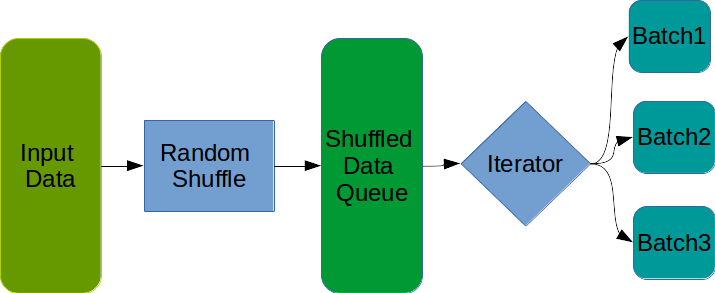


In [8]:
# Load MNIST Dataset
num_epochs = 5               # Set the number of epochs i.e. number of time the entire data is trained
batch_size = 64              # How many data points are trained at a time
learning_rate = 0.001        # The MOST important tuning parameter

train_data = datasets.MNIST(train=True, transform= transforms.ToTensor(),
                            download=True, root = './data/')
test_data = datasets.MNIST(train=False, transform = transforms.ToTensor(),
                           root = './data')

track_loss = []
start_time = time()

# Create data pipeline
train_pip = torch.utils.data.DataLoader(dataset = train_data,
                                        batch_size = batch_size,
                                        shuffle =  True)
test_pip = torch.utils.data.DataLoader(dataset = test_data,
                                       batch_size= batch_size,
                                       shuffle = False)
van_cnn = VannilaCNN()
van_cnn.cuda()

load_time = time() - start_time

# Loss Function
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(van_cnn.parameters(), lr =  learning_rate)

print("Training the Vanilla CNN Model")
print("-----------------------------------------")
start_time = time()
# Train the Model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_pip):
        images = Variable(images).cuda()
        labels = Variable(labels).cuda()

        # Forward + Backward + Optimize
        optimizer.zero_grad()             # Zero the gradients
        outputs = van_cnn(images)         # Compute the Forward output
        loss = loss_func(outputs, labels)
        loss.backward()                   # Compute the Backward pass
        optimizer.step()                  # Optimize
        track_loss.append(loss.data[0])
        if (i + 1) % 10 == 0:
            print('Epoch [{0:}/{1:}], Iter [{2:3d}/{3:3d}] Loss: {4:.4f}'.format
                  (epoch + 1, num_epochs, i + 1, len(train_data) // batch_size, loss.data[0]))

train_time = time() - start_time 

print("-----------------------------------------")
print("Testing the trained CNN")
start_time = time()

# Test the Model
van_cnn.eval()                              # Change model to 'eval' mode (BN uses moving mean/var).
correct = 0
total = 0
for images, labels in test_pip:
    images = Variable(images).cuda()               # Load the test image
    outputs = van_cnn(images)                       # Compute the output of the network
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.cpu() == labels).sum()   # Check the correctness of the label

test_time = time() - start_time

print("Test Accuracy of the model on the 10000 test images:{}%".format(100 * correct / total))

print("-----------------------------------------")
print("Load  Time :{} \nTrain Time :{} \nTest  Time :{}".format(load_time, train_time, test_time))

torch.save(van_cnn.state_dict(), 'kaim_cnn.pkl')    # Save the Trained Model

plt.figure()
plt.plot(track_loss, lw=2)
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.savefig('CNN_Loss.png')
plt.show()

Training the Vanilla CNN Model
-----------------------------------------
Epoch [1/5], Iter [ 10/937] Loss: 1.5617
Epoch [1/5], Iter [ 20/937] Loss: 0.7530
Epoch [1/5], Iter [ 30/937] Loss: 0.6352
Epoch [1/5], Iter [ 40/937] Loss: 0.4481
Epoch [1/5], Iter [ 50/937] Loss: 0.3709
Epoch [1/5], Iter [ 60/937] Loss: 0.4086
Epoch [1/5], Iter [ 70/937] Loss: 0.2050
Epoch [1/5], Iter [ 80/937] Loss: 0.1802
Epoch [1/5], Iter [ 90/937] Loss: 0.1601
Epoch [1/5], Iter [100/937] Loss: 0.1531
Epoch [1/5], Iter [110/937] Loss: 0.1394
Epoch [1/5], Iter [120/937] Loss: 0.1964
Epoch [1/5], Iter [130/937] Loss: 0.1532
Epoch [1/5], Iter [140/937] Loss: 0.1057
Epoch [1/5], Iter [150/937] Loss: 0.1380
Epoch [1/5], Iter [160/937] Loss: 0.0888
Epoch [1/5], Iter [170/937] Loss: 0.0709
Epoch [1/5], Iter [180/937] Loss: 0.0964
Epoch [1/5], Iter [190/937] Loss: 0.0709
Epoch [1/5], Iter [200/937] Loss: 0.1032
Epoch [1/5], Iter [210/937] Loss: 0.1440
Epoch [1/5], Iter [220/937] Loss: 0.1101
Epoch [1/5], Iter [230/93

Epoch [3/5], Iter [170/937] Loss: 0.0164
Epoch [3/5], Iter [180/937] Loss: 0.0209
Epoch [3/5], Iter [190/937] Loss: 0.0025
Epoch [3/5], Iter [200/937] Loss: 0.0436
Epoch [3/5], Iter [210/937] Loss: 0.0135
Epoch [3/5], Iter [220/937] Loss: 0.0257
Epoch [3/5], Iter [230/937] Loss: 0.0113
Epoch [3/5], Iter [240/937] Loss: 0.0158
Epoch [3/5], Iter [250/937] Loss: 0.0139
Epoch [3/5], Iter [260/937] Loss: 0.0183
Epoch [3/5], Iter [270/937] Loss: 0.0108
Epoch [3/5], Iter [280/937] Loss: 0.0197
Epoch [3/5], Iter [290/937] Loss: 0.0059
Epoch [3/5], Iter [300/937] Loss: 0.0126
Epoch [3/5], Iter [310/937] Loss: 0.0150
Epoch [3/5], Iter [320/937] Loss: 0.0287
Epoch [3/5], Iter [330/937] Loss: 0.0524
Epoch [3/5], Iter [340/937] Loss: 0.0098
Epoch [3/5], Iter [350/937] Loss: 0.0026
Epoch [3/5], Iter [360/937] Loss: 0.0955
Epoch [3/5], Iter [370/937] Loss: 0.0099
Epoch [3/5], Iter [380/937] Loss: 0.0392
Epoch [3/5], Iter [390/937] Loss: 0.0630
Epoch [3/5], Iter [400/937] Loss: 0.0287
Epoch [3/5], Ite

Epoch [5/5], Iter [340/937] Loss: 0.0031
Epoch [5/5], Iter [350/937] Loss: 0.0014
Epoch [5/5], Iter [360/937] Loss: 0.0015
Epoch [5/5], Iter [370/937] Loss: 0.0041
Epoch [5/5], Iter [380/937] Loss: 0.0110
Epoch [5/5], Iter [390/937] Loss: 0.0151
Epoch [5/5], Iter [400/937] Loss: 0.0017
Epoch [5/5], Iter [410/937] Loss: 0.0014
Epoch [5/5], Iter [420/937] Loss: 0.0100
Epoch [5/5], Iter [430/937] Loss: 0.0055
Epoch [5/5], Iter [440/937] Loss: 0.0037
Epoch [5/5], Iter [450/937] Loss: 0.0138
Epoch [5/5], Iter [460/937] Loss: 0.0031
Epoch [5/5], Iter [470/937] Loss: 0.0421
Epoch [5/5], Iter [480/937] Loss: 0.0211
Epoch [5/5], Iter [490/937] Loss: 0.0142
Epoch [5/5], Iter [500/937] Loss: 0.0515
Epoch [5/5], Iter [510/937] Loss: 0.0112
Epoch [5/5], Iter [520/937] Loss: 0.0031
Epoch [5/5], Iter [530/937] Loss: 0.1173
Epoch [5/5], Iter [540/937] Loss: 0.0314
Epoch [5/5], Iter [550/937] Loss: 0.0039
Epoch [5/5], Iter [560/937] Loss: 0.0184
Epoch [5/5], Iter [570/937] Loss: 0.0419
Epoch [5/5], Ite

### Tricks of the Trade
- Always Shuffle the data, so that the network never trains on the same minibatch (even shuffle every epoch)
- Data Augmentation - flipping, translating, rotating etc.
- Use Xavier's initialization method - Gaussian RVs with $\sigma = 2/(N_{in} + N_{out})$ [Logic - The variance of the random weights must be the same across the layer]
- Tune the **Learning Rate** using cross-validation
- Test the network on a subset of the data and check for convergence
- **Regularize!** - Dropout or BatchNorm
- Use RELU(or its variants) rather than Sigmoid ot Tanh
